# Introduction of mathematical optimization and Ising optimization

In [3]:
# 各種ツールのupdate
!pip install -U jijzept jijmodeling
!pip install jijmodeling-transpiler matplotlib
!pip install -U jijmodeling-transpiler

## 本章の構成

1. JijModelingを使った最適化問題のモデリング方法を学ぶ　
2. ジョブショップスケジューリング問題を通して具体的な問題を解いてみる
3. JijModeling, JijZeptの裏でどのようにイジングソルバーに情報が伝わっているのかを知る
4. イジングソルバーがどのようにして解いているのかを知る

## JijModelingを使ったモデリング

Documentation: https://www.documentation.jijzept.com/docs/jijmodeling_docs/0quick_start

![](images/JM_Compile.png)

In [4]:
# ライブラリのインポート
import jijzept as jz
import jijmodeling as jm
import jijmodeling.transpiler as jmt

### ジョブショップスケジューリング

![](images/job_shop_scheduling.webp)

#### データを定式化しよう

- $N$ 個のジョブ
- 各ジョブの実行時間 $L = \{L_0, L_1, \cdots, L_{N-1}\}$
- $M$ 個のコンピュータ

In [6]:
N = jm.Placeholder("N")
L = jm.Placeholder("L", shape=N)
M = jm.Placeholder("M")

#### 変数を定式化しよう

In [8]:
x = jm.Binary("x", shape=(N, M))

#### 数理モデルを作ろう

In [12]:
problem = jm.Problem("job scheduling")


i = jm.Element("i", (0, N))
j = jm.Element("j", (0, M))
A0 = jm.Sum(i, L[i] * x[i, 0])
Aj = jm.Sum(i, L[i] * x[i, j])
problem += jm.Sum((j, j!=0), (A0 - Aj) ** 2)


problem += jm.Constraint("onehot", x[i, :] == 1, forall=i)

problem

In [20]:
# set a list of jobs
inst_L = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# set the number of Nodes
inst_M = 3
instance_data = {'L': inst_L, 'M': inst_M, 'N': len(inst_L)}

In [26]:
import jijzept as jz

# set sampler
config_path = "./config.toml"
sampler = jz.JijSASampler()
# solve problem
multipliers = {"onehot": 0.5}
results = sampler.sample_model(problem, instance_data, multipliers, num_reads=100, search=True)

In [23]:
results.error_message

{}

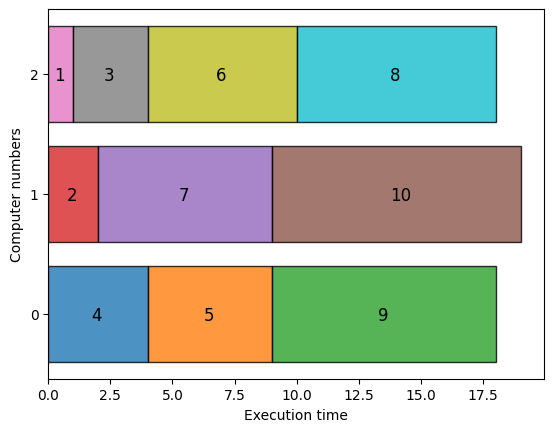

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# extract feasible solution
feasibles = results.feasible()
# get the index of the lowest objective function
objectives = np.array(feasibles.evaluation.objective)
lowest_index = np.argmin(objectives)
# get indices of x = 1
indices, _, _ = feasibles.record.solution['x'][lowest_index]
# get task number and execution node
tasks, nodes = indices
# get instance information
L = instance_data['L']
M = instance_data['M']
# initialize execution time
exec_time = np.zeros(M, dtype=np.int64)
# compute summation of execution time each nodes
for i, j in zip(tasks, nodes):
    plt.barh(j, L[i], left=exec_time[j],ec="k", linewidth=1,alpha=0.8)
    plt.text(exec_time[j] + L[i] / 2.0 - 0.25 ,j-0.05, str(i+1),fontsize=12)
    exec_time[j] += L[i]
plt.yticks(range(M))
plt.ylabel('Computer numbers')
plt.xlabel('Execution time')
plt.show()

## DAでの実行

In [29]:
import jijzept as jz

# set sampler
config_path = "./config.toml"
sampler = jz.JijDA4Sampler()

da4_param = jz.JijDA4SolverParameters()
# solve problem
multipliers = {"onehot": 0.5}
results = sampler.sample_model(problem, instance_data)